# GPT 4o Analysis

In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI

from token_latency_functions import (
    run_latency_experiments, 
    split_text_by_token_lengths, 
    get_token_count,
    fastest_input_token_times_fig,
    fastest_output_token_times_fig,
    preprocess_latency_data,
    quantile_regression,
    standard_linear_regression,
    plot_3d,
    save_latency_model_results
)

In [2]:
client = OpenAI()

model_name = "gpt-4o-2024-05-13"

folder = f"{model_name}/"

os.makedirs(folder, exist_ok=True)

### Read in network latency constant

In [3]:
file_name = "network_latency/network_times.json"

with open(file_name, "r") as jf:
    network_times = json.load(jf)

network_latency = np.quantile(network_times, 0.1)
print("Network latency, 10% quantile:", round(network_latency, 4))

Network latency, 10% quantile: 0.1086


# Data Collection
(will overwrite existing data - skip to data analysis to read in existing data)

### 1. Varied inputs, short output

In [7]:
books_folder = "prompts/books"
texts  = []

for filename in os.listdir(books_folder):
    path = os.path.join(books_folder, filename)
    with open(path) as f:
        texts.append(f.read())

text = "\n\n".join(texts)
print(len(text))

6658611


In [6]:
token_lengths = list(range(5000, 126000, 10000))
prompts = split_text_by_token_lengths(text, token_lengths)

inject_message = "Now, I just want you to respond 'yes', exactly as I have it here (lowercase, no punctuation). Your response: "

messages = []
for msg in prompts:
    message = msg + inject_message
    messages.append(message)
    print(get_token_count(message))

NameError: name 'text' is not defined

In [6]:
run_latency_experiments(
    prompts=messages,
    client=client,
    model_name=model_name,
    iterations=50,
    csv_path=folder+"input_token_times.csv",
)

Prompt 0: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 1: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 2: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 3: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 4: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 5: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 6: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 7: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 8: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 9: 50 iterations
	Ite

In [6]:
file_name = folder + "input_token_times.csv"

input_times = pd.read_csv(file_name)

print(f"{len(input_times)} data points collected")

2200 data points collected


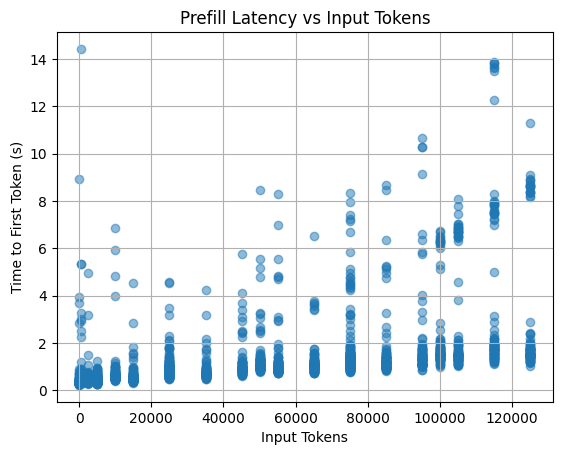

In [7]:
plt.scatter(input_times.input_tokens, input_times.prefill_latency, alpha=0.5)
plt.title("Prefill Latency vs Input Tokens")
plt.xlabel("Input Tokens")
plt.ylabel("Time to First Token (s)")
plt.grid(True)

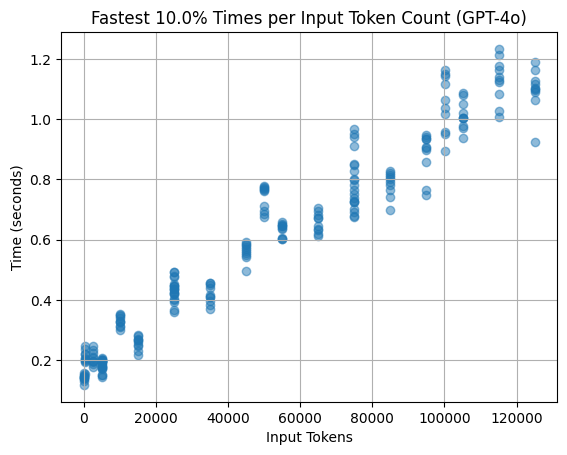

In [9]:
fastest_input_token_times_fig(
    input_times, 
    model_name="GPT-4o", 
    network_latency=network_latency, 
    quantile=0.1
)

### 2. Short input, varied output

In [11]:
file_name = "prompts/prompts.json"

with open(file_name, "r") as jf:
    prompts = json.load(jf)

In [9]:
run_latency_experiments(
    prompts=prompts,
    client=client,
    model_name=model_name,
    iterations=25,
    csv_path=folder+"output_token_times.csv",
)

Prompt 0: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25
Prompt 1: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25
Prompt 2: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25
Prompt 3: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25
Prompt 4: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25
Prompt 5: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25

All done. Data written to gpt-4-0613/output_token_times.csv.


In [12]:
file_name = folder + "output_token_times.csv"

output_times = pd.read_csv(file_name)

print(f"{len(output_times)} data points collected")

300 data points collected


/home/campbellc/Documents/scripts/llm-impact-taskforce/openai-latency-regression/token_latency_functions.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fastest_10 = output_times.groupby("token_bin", group_keys=False).apply(


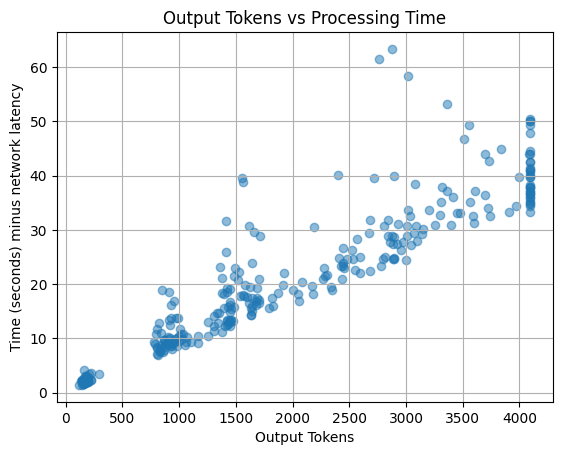

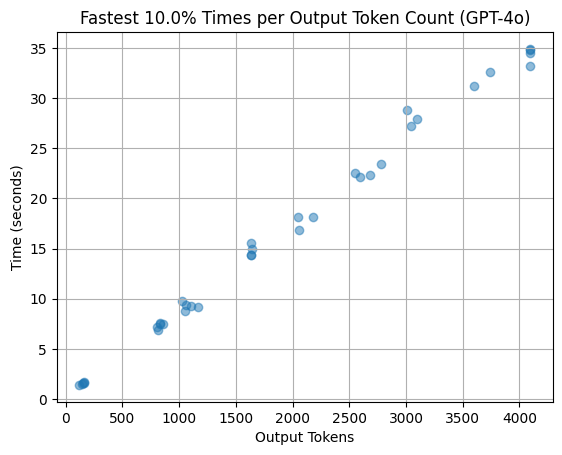

In [13]:
output_times['time_minus_network_latency'] = output_times['total_time'] - network_latency

# All times
plt.figure()
plt.scatter(output_times['output_tokens'], output_times['time_minus_network_latency'], alpha=0.5)
plt.title("Output Tokens vs Processing Time")
plt.xlabel("Output Tokens")
plt.ylabel("Time (seconds) minus network latency")
plt.grid(True)


fastest_output_token_times_fig(
    output_times,
    output_bins = range(0, 5000, 500),
    model_name = "GPT-4o",
    network_latency=network_latency,
    quantile=0.1
)

### 3. Varied input and output

In [15]:
from itertools import product
import json

token_lengths = list(range(100000, 125000, 5000))
prompts = split_text_by_token_lengths(text, token_lengths)

with open("prompts/prompts.json") as jf:
    instructions = json.load(jf)[4:]

combined = [f"{p} {instr}" for p, instr in product(prompts, instructions)]

output_token_limit = 4000
translate_prompts = []
for p in prompts:
    if get_token_count(p) <= output_token_limit:
        translate_prompts.append(
            "Translate the following text into German, and output only the translation:\n\n"
            + p
        )

all_prompts: list[str] = combined + translate_prompts
print(len(all_prompts))

10


In [17]:
run_latency_experiments(
    prompts=all_prompts,
    client=client,
    model_name=model_name,
    iterations=20,
    csv_path=folder+"mid_token_times.csv",
)

Prompt 0: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 1: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 2: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 3: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 4: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 5: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 6: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 7: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 8: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 9: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 10: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 11: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 12: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 13: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 14: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 15: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 16: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 17: 20 iterations

In [13]:
file_name = folder + "mid_token_times.csv"

mid_times = pd.read_csv(file_name)

print(f"{len(mid_times)} data points collected.")

1040 data points collected.


# Data Analysis

In [4]:
file_name = folder + "combined_data.csv"

input_times = pd.read_csv(folder + "input_token_times.csv")
output_times = pd.read_csv(folder + "output_token_times.csv")
mid_times = pd.read_csv(folder + "mid_token_times.csv")

combined_data = pd.concat(
    [mid_times, input_times, output_times],
    ignore_index=True,
)

combined_data["time_minus_network_latency"] = combined_data["total_time"] - network_latency

combined_data.to_csv(file_name, index=False)
print(f"Combined data has {len(combined_data)} points")

Combined data has 3540 points


### Create long dataframe, a separate measurement for each token

In [5]:
import ast

df = combined_data.copy()
df['token_latencies'] = df['token_latencies'].apply(ast.literal_eval)
df['obs_id'] = df.index
long_df = (
    df
    .explode('token_latencies')
    .rename(columns={'token_latencies':'latency'})
    .reset_index(drop=True)
)
long_df['latency'] = long_df['latency'].astype(float)
long_df['output_tokens'] = long_df.groupby('obs_id').cumcount() + 1
long_df['total_time'] = long_df.groupby('obs_id')['latency'].cumsum()
long_df['time_minus_network_latency'] = long_df.total_time - network_latency

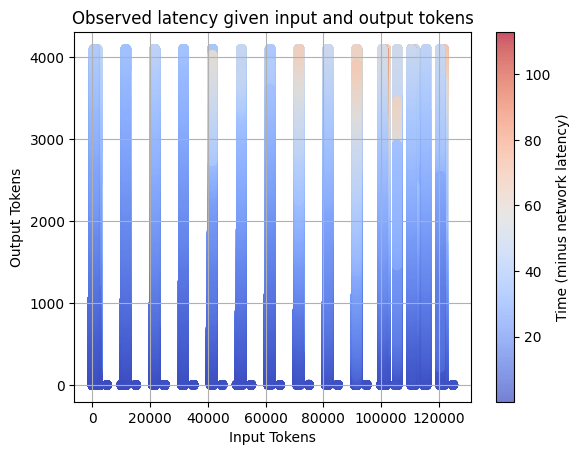

In [6]:
sc = plt.scatter(long_df["input_tokens"], long_df["output_tokens"], c=long_df["time_minus_network_latency"], cmap="coolwarm", alpha=0.7)
plt.colorbar(sc, label="Time (minus network latency)")
plt.xlabel("Input Tokens")
plt.ylabel("Output Tokens")
plt.title("Observed latency given input and output tokens")
plt.grid(True)

In [6]:
long_df[long_df.cached_tokens > 0]

,input_tokens,output_tokens,reasoning_tokens,cached_tokens,total_time,prefill_latency,latency,time_minus_network_latency,obs_id


In [7]:
max_input_tokens = long_df.input_tokens.max()
max_output_tokens = long_df.output_tokens.max()

long_df = preprocess_latency_data(long_df, max_input_tokens, max_output_tokens)

## How does latency accumulate differently for shorter and longer input/output?

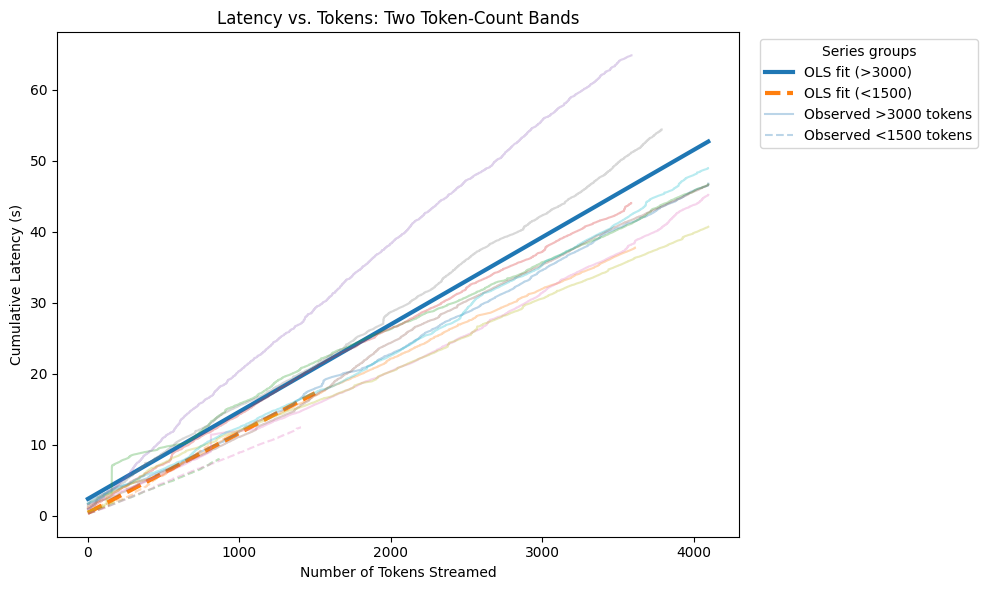

In [9]:
import statsmodels.api as sm

sample_size = 10

group1_min_tokens = 3000
group2_max_tokens = 1500

obs_summary = long_df.groupby("obs_id").agg(
    max_output_tokens=("output_tokens", "max"),
    input_tokens=("input_tokens", "first"),
)

group1 = obs_summary[
    (obs_summary["max_output_tokens"] > group1_min_tokens)
    & (obs_summary["input_tokens"] > group1_min_tokens)
].index

group2 = obs_summary[
    (obs_summary["max_output_tokens"] < group2_max_tokens)
    & (obs_summary["input_tokens"] < group2_max_tokens)
].index

df_large = long_df[long_df["obs_id"].isin(group1)]
df_small = long_df[long_df["obs_id"].isin(group2)]


# Fit OLS
X1 = sm.add_constant(df_large["output_tokens"])
model_large = sm.OLS(df_large["total_time"], X1).fit()

X2 = sm.add_constant(df_small["output_tokens"])
model_small = sm.OLS(df_small["total_time"], X2).fit()


# Plot fitted lines
xr1 = np.linspace(df_large["output_tokens"].min(), df_large["output_tokens"].max(), 100)
xr2 = np.linspace(df_small["output_tokens"].min(), df_small["output_tokens"].max(), 100)

yr1 = model_large.params["const"] + model_large.params["output_tokens"] * xr1
yr2 = model_small.params["const"] + model_small.params["output_tokens"] * xr2

plt.figure(figsize=(10, 6))
plt.plot(xr1, yr1, color="C0", linewidth=3, label=f"OLS fit (>{group1_min_tokens})")
plt.plot(
    xr2,
    yr2,
    color="C1",
    linewidth=3,
    linestyle="--",
    label=f"OLS fit (<{group2_max_tokens})",
)

# Plot observed data
sample1 = np.random.choice(
    group1, size=min(sample_size, len(group1)), replace=False
)
sample2 = np.random.choice(
    group2, size=min(sample_size, len(group2)), replace=False
)
for i, obs_id in enumerate(sample1):
    tmp = long_df[long_df["obs_id"] == obs_id]
    plt.plot(
        tmp["output_tokens"],
        tmp["total_time"],
        linestyle="-",
        alpha=0.3,
        label=f"Observed >{group1_min_tokens} tokens" if i == 0 else "",
    )

for i, obs_id in enumerate(sample2):
    tmp = long_df[long_df["obs_id"] == obs_id]
    plt.plot(
        tmp["output_tokens"],
        tmp["total_time"],
        linestyle="--",
        alpha=0.3,
        label=f"Observed <{group2_max_tokens} tokens" if i == 0 else "",
    )

plt.xlabel("Number of Tokens Streamed")
plt.ylabel("Cumulative Latency (s)")
plt.title("Latency vs. Tokens: Two Token‐Count Bands")
plt.legend(title="Series groups", loc="upper left", bbox_to_anchor=(1.02, 1))
plt.tight_layout()

In [10]:
import statsmodels.formula.api as smf

df_large["group"] = "large"
df_small["group"] = "small"
pooled = pd.concat([df_large, df_small], ignore_index=True)

interaction_model = smf.ols(
    "total_time ~ output_tokens * group",
    data=pooled
).fit()

print(interaction_model.summary())

/var/folders/nh/93zvqh815h72t6r93syl9h7c0000gp/T/ipykernel_30718/3327877594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_large["group"] = "large"
/var/folders/nh/93zvqh815h72t6r93syl9h7c0000gp/T/ipykernel_30718/3327877594.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small["group"] = "small"


                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                 3.777e+06
Date:                Sat, 05 Jul 2025   Prob (F-statistic):               0.00
Time:                        18:30:16   Log-Likelihood:            -6.8854e+06
No. Observations:             2118836   AIC:                         1.377e+07
Df Residuals:                 2118832   BIC:                         1.377e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [11]:
#  Test if the intercepts are equal (H0: group[T.large] = 0)
print("\nIntercept difference test:")
print(interaction_model.t_test("group[T.small] = 0"))

#  Test if the slopes are equal (H0: output_tokens:group[T.large] = 0)
print("\nSlope difference test:")
print(interaction_model.t_test("output_tokens:group[T.small] = 0"))

#  Joint F-test (both intercept & slope differences simultaneously)
print("\nJoint test (intercept AND slope):")
print(interaction_model.f_test([
    "group[T.small] = 0",
    "output_tokens:group[T.small] = 0"
]))


Intercept difference test:
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -1.9536      0.030    -64.582      0.000      -2.013      -1.894

Slope difference test:
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0011   4.39e-05    -23.942      0.000      -0.001      -0.001

Joint test (intercept AND slope):
<F test: F=10455.354276923357, p=0.0, df_denom=2.12e+06, df_num=2>


## Quantile Regression

In [8]:
quant_result, quant_loss, quant_base_loss = quantile_regression(
    long_df, 
    time_column="time_minus_network_latency",
    quantile=0.10
)

                             QuantReg Regression Results                              
Dep. Variable:     time_minus_network_latency   Pseudo R-squared:               0.7018
Model:                               QuantReg   Bandwidth:                      0.1430
Method:                         Least Squares   Sparsity:                        5.736
Date:                        Thu, 10 Jul 2025   No. Observations:              2575124
Time:                                10:47:01   Df Residuals:                  2575120
                                                Df Model:                            3
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1365      0.003     43.393      0.000       0.130       0.143
in_k           0.0080   4.23e-05    189.646      0.000       0.008       0.008
out_k          8.3507      0.002   4922.048      0.000       8.347       8.

In [9]:
fig = plot_3d(
    long_df,
    model=quant_result,
    title="Quantile Regression (10th percentile)",
    observed_z_col="time_minus_network_latency"
)
fig.write_html(folder + "quant_reg_surface.html")

In [10]:
fig.show()

## Ordinary Least Squares

In [11]:
ols_result, mse, mse_base = standard_linear_regression(
    long_df, 
    time_column="time_minus_network_latency"
)

                                OLS Regression Results                                
Dep. Variable:     time_minus_network_latency   R-squared:                       0.882
Model:                                    OLS   Adj. R-squared:                  0.882
Method:                         Least Squares   F-statistic:                 6.410e+06
Date:                        Thu, 10 Jul 2025   Prob (F-statistic):               0.00
Time:                                10:47:19   Log-Likelihood:            -7.8715e+06
No. Observations:                     2575124   AIC:                         1.574e+07
Df Residuals:                         2575120   BIC:                         1.574e+07
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [12]:
fig = plot_3d(
    long_df,
    model=ols_result,
    title="Ordinary Least Squares Regression",
    observed_z_col="time_minus_network_latency"
)
fig.write_html(folder + "ols_surface.html")

In [13]:
fig.show()

## Save coefficients

In [15]:
coeff_df = save_latency_model_results(
    quant_result, 
    quant_loss, 
    quant_base_loss, 
    ols_result, 
    mse, 
    mse_base, 
    model_name=model_name
)

Results saved to latency_coefficients.csv
